# Initial Data Cleaning

In [1]:
# pandas and numpy for data manipulation
import pandas as pd
import numpy as np

from scipy import stats
import math
from math import log
from sklearn import preprocessing
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
import sklearn.metrics as metrics

# matplotlit and seaborn for visualizations
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
matplotlib.rc('xtick', labelsize=10) 
matplotlib.rc('ytick', labelsize=10) 

import seaborn as sns
sns.set_style("darkgrid")
# Suppress warnings from pandas
import warnings
warnings.filterwarnings('ignore')

pd.options.display.float_format = '{:,.2f}'.format

In [2]:
#Load Data
df = pd.read_csv('loan.csv')
#drop completely blank instances
df=df.dropna(how='all', axis=1)
# removing rows that do not meet Lending Club's credit policy and are in progress
df1=df[(df['loan_status'] == 'Fully Paid')|
                       (df['loan_status'] == 'Charged Off')|
                          (df['loan_status'] == 'Default')]
# converting loan_status to numerical values where 1 represents paid and 0 represents charged off 
df1['loan_status_target'] = df1[['loan_status']].replace({'Fully Paid':1, 'Charged Off':0,'Default':0})
# removing columns with only one unique value 
df1 = df1.loc[:,df1.apply(func=pd.Series.nunique, args=(False)) > 1]
# remove columns with majority missing variables
df_missing = (df1.isnull().sum() / len(df1)).sort_values(ascending = False)
cols_missing=list(df_missing.index[df_missing > 0.75])

print('There were %d columns with more than 75%% missing values' % len(df_missing.index[df_missing > 0.75]))

#drop columns with too many missing values 
df2=df1.drop(columns = cols_missing)

# creating a mapping dictionary for the sub_grade column
ranked_sub_grade = df2.sub_grade.value_counts().sort_index().index.tolist()
sub_grade_map = {sub_grade:(index+1) for index, sub_grade in enumerate(ranked_sub_grade)}

# creating a mapping dictionary for the grade column
ranked_grade = df2.grade.value_counts().sort_index().index.tolist()
grade_map = {grade:(index+1) for index, grade in enumerate(ranked_grade)}

# Map for the employment length column
mapping_dict = {"emp_length": {
                               "10+ years": 10,
                               "9 years": 9,
                               "8 years": 8,
                               "7 years": 7,
                               "6 years": 6,
                               "5 years": 5,
                               "4 years": 4,
                               "3 years": 3,
                               "2 years": 2,
                               "1 year": 1,
                               "< 1 year": 0,
                               "n/a": 0, 
                                "nan": 0
                               },
                "sub_grade": sub_grade_map,
                "grade": grade_map
               }
#apply mappings
df2=df2.replace(mapping_dict)
df2['emp_length']=df2.emp_length.fillna(0)

There were 35 columns with more than 75% missing values


# Data Exploration
1. Exploration of the continuous variables
2. Exploration of the categorical variables

## Continuous Variable Exploration
plotting the correlation matrix will give us a sense of how much variable reduction is possible

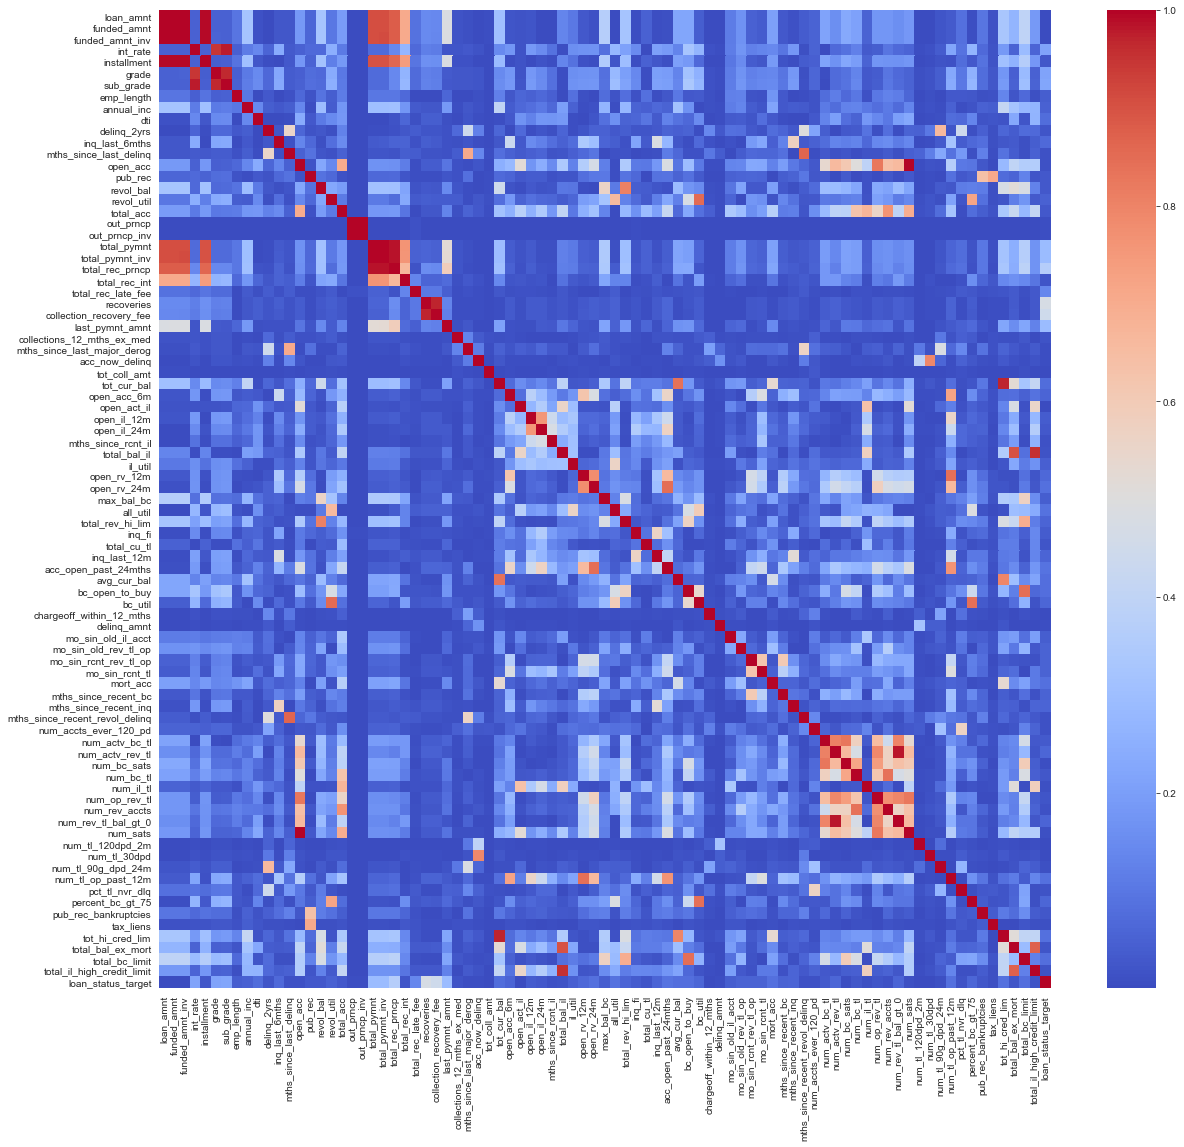

In [3]:
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']

df_corr36 = df2[df2.term.str.contains('36',case=False)]
df_corr36 = df_corr36.select_dtypes(include=numerics)

corr36= df_corr36.corr().abs()
_, ax = plt.subplots(figsize=(20,18))
_ = sns.heatmap(corr36, ax=ax,
               xticklabels=corr36.columns.values,
               yticklabels=corr36.columns.values,
               cmap='coolwarm')

In [234]:
df_corr36.shape

(988774, 85)

Correlation matrix shows pockets of colinear features that can be combined or dropped

In [4]:
# Threshold for identifying correlated variables
threshold = 0.75

# Upper triangle of correlations
upper = corr36.where(np.triu(np.ones(corr36.shape), k=1).astype(np.bool))
upper.head()

# Select columns with correlations above threshold
highly_colinear = [column for column in upper.columns if any(upper[column] > threshold)]

highly_colinear

['funded_amnt',
 'funded_amnt_inv',
 'installment',
 'grade',
 'sub_grade',
 'out_prncp_inv',
 'total_pymnt',
 'total_pymnt_inv',
 'total_rec_prncp',
 'total_rec_int',
 'collection_recovery_fee',
 'open_il_24m',
 'open_rv_24m',
 'total_rev_hi_lim',
 'acc_open_past_24mths',
 'avg_cur_bal',
 'bc_util',
 'mths_since_recent_revol_delinq',
 'num_actv_rev_tl',
 'num_bc_sats',
 'num_op_rev_tl',
 'num_rev_accts',
 'num_rev_tl_bal_gt_0',
 'num_sats',
 'num_tl_30dpd',
 'num_tl_op_past_12m',
 'percent_bc_gt_75',
 'tot_hi_cred_lim',
 'total_bal_ex_mort',
 'total_bc_limit',
 'total_il_high_credit_limit']

In [5]:
print('There are %d features that are highly colinear.' % (len(highly_colinear)))

There are 31 features that are highly colinear.


In [6]:
#query to analyze which features most strongly correlate with the target variable
corr36.loan_status_target.sort_values(ascending=False).head(20)

loan_status_target        1.00
recoveries                0.48
collection_recovery_fee   0.45
total_rec_prncp           0.36
total_pymnt               0.29
total_pymnt_inv           0.29
last_pymnt_amnt           0.29
sub_grade                 0.22
int_rate                  0.21
grade                     0.21
total_rec_late_fee        0.14
acc_open_past_24mths      0.09
all_util                  0.09
num_tl_op_past_12m        0.08
tot_hi_cred_lim           0.08
mort_acc                  0.08
open_rv_24m               0.08
bc_open_to_buy            0.08
avg_cur_bal               0.08
total_bc_limit            0.08
Name: loan_status_target, dtype: float64

there is a strong relationship between loan status, total_pymnt, and int_rate

In [238]:
#Take a closer look at the relation between the target variable, interest rate, and loan amount 
pd.pivot_table(df2,index=['term','loan_status_target'],values=['total_pymnt','int_rate','loan_amnt','grade','dti']
               ,aggfunc={'total_pymnt':np.mean,'int_rate':np.mean,'loan_amnt':np.mean,'grade':len})

grade  int_rate  loan_amnt  total_pymnt
term       loan_status_target                                          
 36 months 0                   159169     14.16  12,590.29     6,892.14
           1                   829605     11.74  12,534.84    14,227.96
 60 months 0                   102517     18.12  20,142.75    10,300.35
           1                   212347     16.15  20,374.28    25,080.77

- interest is lower for fully paid loans, total payment is higher for fully paid loans, while loan amounts are the same
- this confirms what is generally expected of the interest and risk tradeoff for the lending industry
- similar pattern with 60 months loans 
- there appear to be significantly more success in 36month loans

In [269]:
df2.groupby(['term','loan_status_target'])['dti'].describe()

count  mean   std   min   25%   50%   75%  \
term       loan_status_target                                                  
 36 months 0                  159,137.00 19.74 11.51  0.00 13.08 19.35 25.96   
           1                  829,449.00 17.53 10.19 -1.00 11.16 16.84 23.20   
 60 months 0                  102,487.00 20.82 10.91  0.00 14.36 20.40 26.88   
           1                  212,253.00 18.76 12.84 -1.00 12.47 18.06 24.14   

                                 max  
term       loan_status_target         
 36 months 0                  999.00  
           1                  999.00  
 60 months 0                  999.00  
           1                  999.00

- Debt to Income ratio tends to be higher for defaulted loans
- however, high stdev reduces predictive capacity of this metric

## Cateogorical Variable Exploration
an unsupervised cluster analysis will reveal trends in our high-dimentional categorical data

In [226]:
#pull only categorical features
nonnumerics = ['object']

dfclust=df2.select_dtypes(include=nonnumerics)

#eliminate irrelevant or large category fields to save memory
dfclust= dfclust.drop(columns = ['earliest_cr_line', 'addr_state', 'issue_d','emp_title','loan_status','title', 'last_pymnt_d', 'zip_code', 'last_credit_pull_d',
                                'hardship_flag', 'disbursement_method', 'debt_settlement_flag'])

dfclust['loan_target_str']=df2[['loan_status_target']].replace({1:'Fully Paid', 0:'dft/chrgoff'})

#check if there are numericals
na_cols = dfclust.shape[0]-dfclust.count()
na_cols[na_cols>0]

Series([], dtype: int64)

In [228]:
#transform categorical variables into dummy variables with one-hot encoding
dfclust_dum=pd.get_dummies(dfclust)
dfclust_dum_array=dfclust_dum.values
dfclust_dum_array.shape

(1303638, 31)

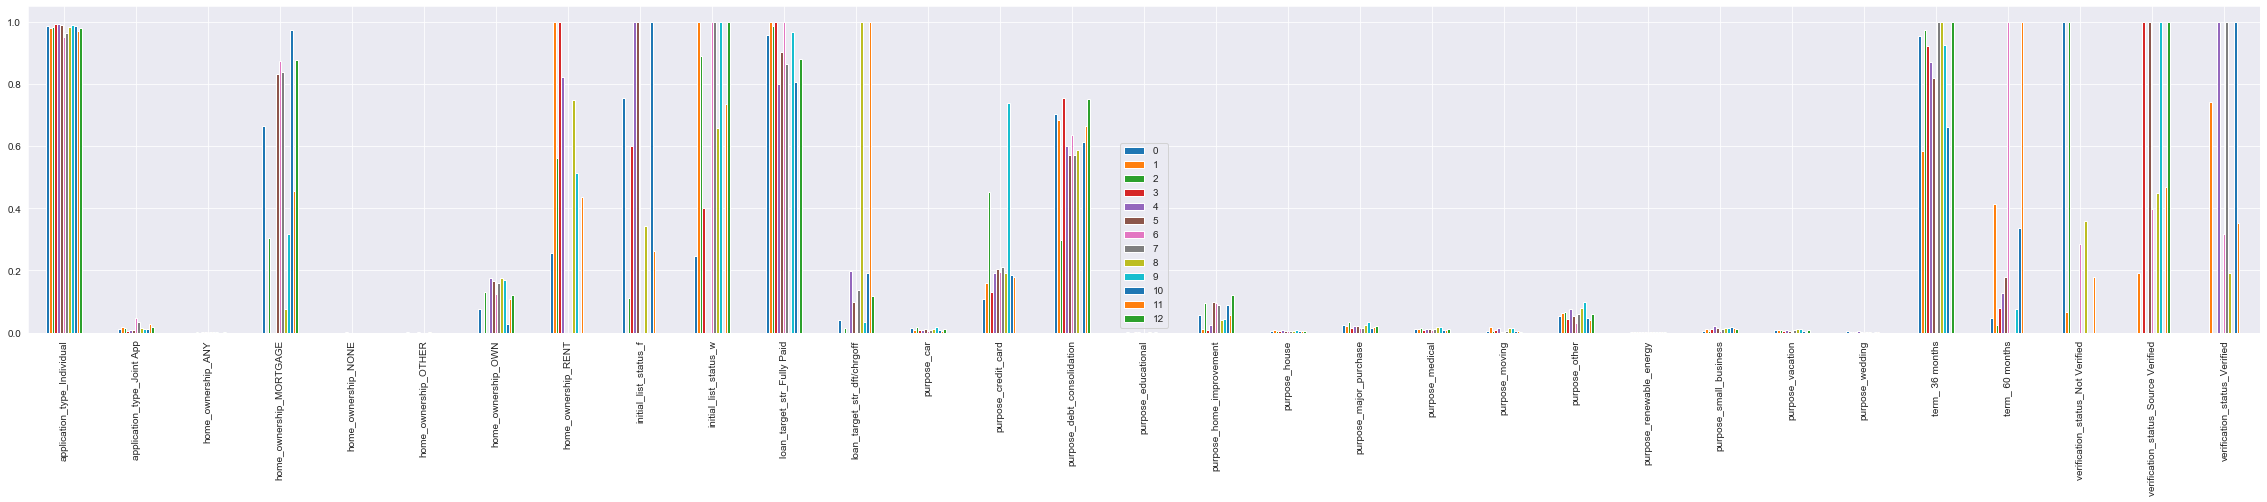

In [229]:
clmns=list(dfclust_dum.columns.values)

#Cluster the data
kmeans = KMeans(n_clusters=13, random_state=0).fit(dfclust_dum_array)
labels = kmeans.labels_

#Glue back to originaal data
dfclust_dum['clusters'] = labels

#plot clusters as clustered bar chart
df_radar=pd.DataFrame(pd.pivot_table(dfclust_dum,index=['clusters'],values=list(dfclust_dum.columns.values),aggfunc=np.mean).to_records())
ax = df_radar.drop(columns = 'clusters').transpose().plot(figsize=(40,6),kind="bar")

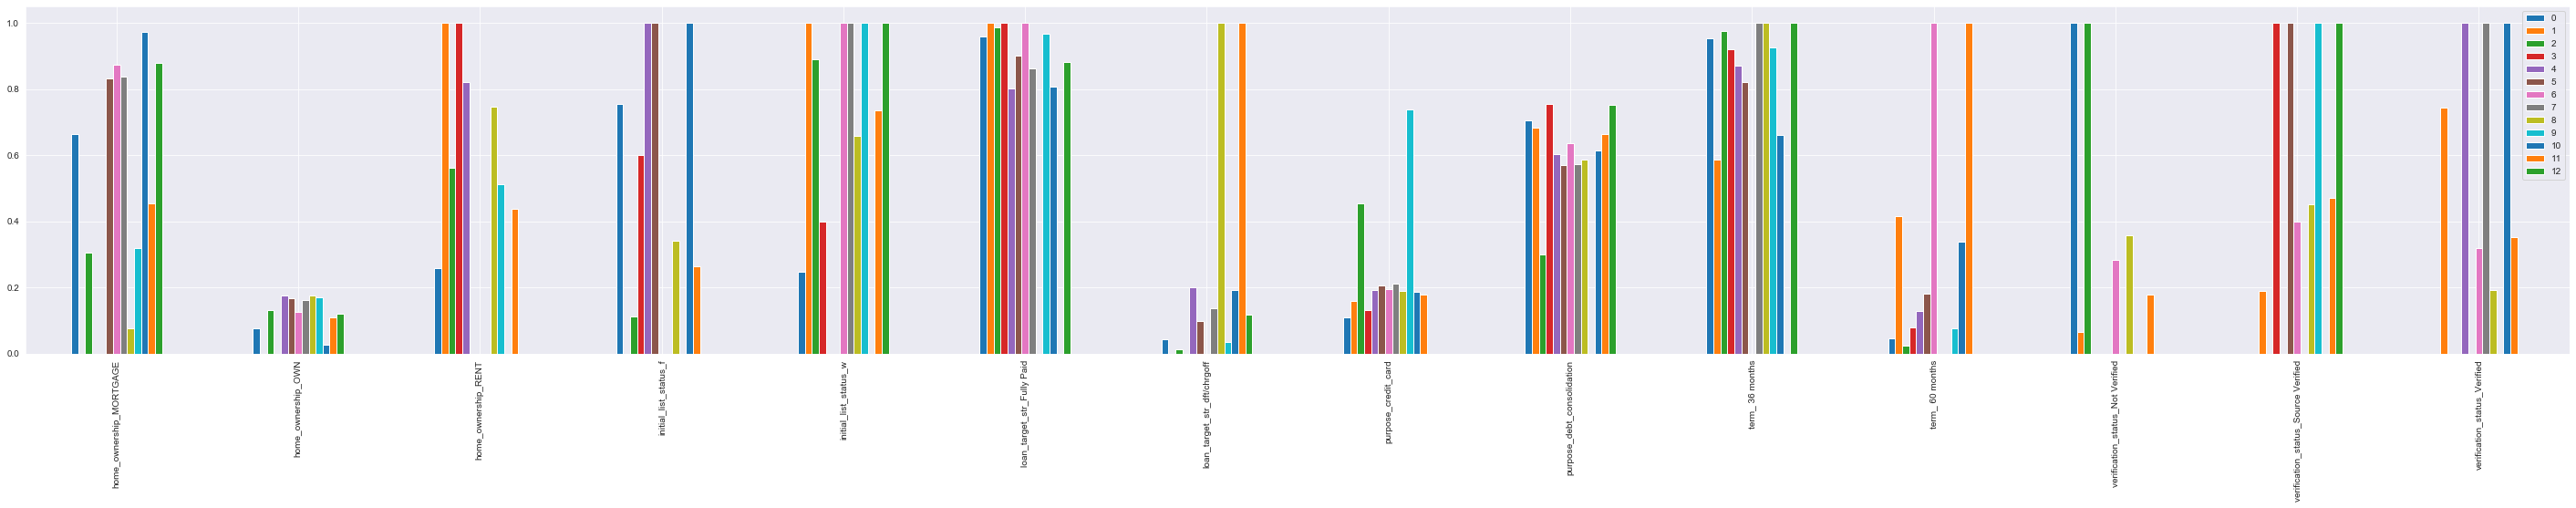

In [231]:
#drop homogeneous variables and replot 
ax = df_radar.drop(columns = ['clusters', 'application_type_Individual',
                             'home_ownership_ANY', 'home_ownership_NONE','home_ownership_OTHER', 'purpose_educational', 'purpose_house',
                             'application_type_Joint App', 'purpose_car', 'purpose_home_improvement', 'purpose_major_purchase',
                             'purpose_medical', 'purpose_moving', 'purpose_other', 'purpose_renewable_energy','purpose_small_business',
                             'purpose_vacation','purpose_wedding'])\
    .transpose().plot(figsize=(50,7),kind="bar")

- clusters 8 and 11 have a very high default rate 
- these high default clusters tend to not own homes or mortgages and tend to be renters 
- they also tend to use the loans for debt consolidation 
- clusters 8 and 11 also have weak income verification status 
- cluster 11 prefers 60 month loans more so than any other cluster and do not subscribe to 36 month loans

Now I want to explore the influence of Lending Club's grading system on the target variable

In [16]:
def plot_var(col_name, full_name, continuous):
    """
    Visualize a variable with and without faceting on the loan status.
    - col_name is the variable name in the dataframe
    - full_name is the full variable name
    - continuous is True if the variable is continuous, False otherwise
    """
    f, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12,3), dpi=90)
    
    # Plot without loan status
    if continuous:
        sns.distplot(df2.loc[loans[col_name].notnull(), col_name], kde=False, ax=ax1)
    else:
        sns.countplot(df2[col_name], order=sorted(df2[col_name].unique()), color='#5975A4', saturation=1, ax=ax1)
    ax1.set_xlabel(full_name)
    ax1.set_ylabel('Count')
    ax1.set_title(full_name)

    # Plot with loan status
    if continuous:
        sns.boxplot(x=col_name, y='loan_status', data=loans, ax=ax2)
        ax2.set_ylabel('')
        ax2.set_title(full_name + ' by Loan Status')
    else:
        charge_off_rates = df2.groupby(col_name)['loan_status'].value_counts(normalize=True).loc[:,'Charged Off']
        sns.barplot(x=charge_off_rates.index, y=charge_off_rates.values, color='#5975A4', saturation=1, ax=ax2)
        ax2.set_ylabel('Fraction of Loans Charged-off')
        ax2.set_title('Charge-off Rate by ' + full_name)
    ax2.set_xlabel(full_name)
    
    plt.tight_layout()

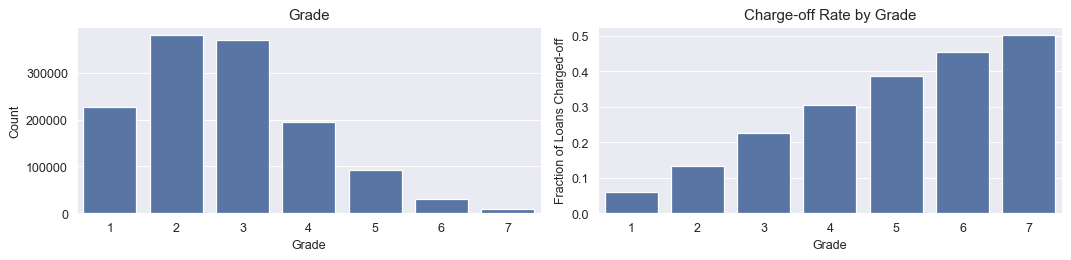

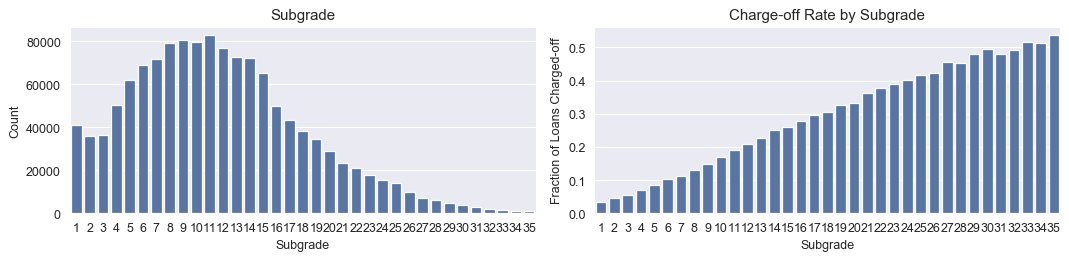

In [241]:
plot_var('grade','Grade', continuous=False)
plot_var('sub_grade','Subgrade', continuous=False)

- Note: grade translates from A through G to 1 through 7 
- There is a negative linear relationship between grade and charge-off rate
- Lower grades have higher proportion of defaulted loans
- Caveat: the samples of loans are much lower at lower grades

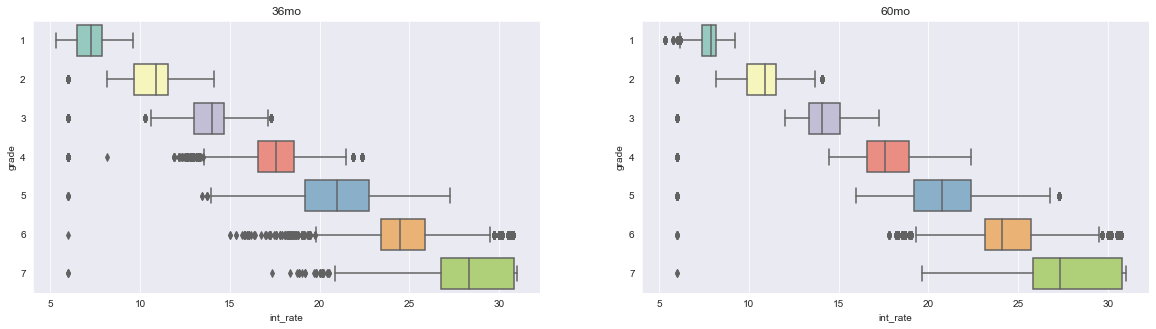

In [242]:
xaxis=df2['grade'].unique().tolist()
data36=df2[df2.term.str.contains('36',case=False)]
data36=data36[['int_rate','grade']]
data60=df2[df2.term.str.contains('60',case=False)]
data60=data60[['int_rate','grade']]


fig,ax=plt.subplots(1,2,figsize=(20,5))
sns.boxplot(x='int_rate', y='grade', data=data36, orient="h",
            palette='Set3', order=pd.Series(xaxis).sort_values(ascending=True).tolist(), ax=ax[0]).set_title('36mo')
sns.boxplot(x='int_rate', y='grade', data=data60, orient="h",
            palette='Set3', order=pd.Series(xaxis).sort_values(ascending=True).tolist(), ax=ax[1]).set_title('60mo')
fig.show()

- variability in interest rates increase as loan rating decreases
- this reduces statistical explainability at lower grade loans 

# Business Analysis
We are interested in evaluating whether the 36 month term loans would make for a good investment.
Please investigate the following. Assume a 36 month investment period for each loan, and exclude
loans with less than 36 months of data available.
- What rate of return have these loans generated on average?

In [247]:
#pull only 36month loans
df_36=df2[df2.term.str.contains('36',case=False)]

#calculate monthly payment to vaildate installment field
Principle=df_36.loan_amnt
interest=df_36.int_rate/100
N=12
Y=3
R=((interest*Principle)/12)/(1-(interest/12+1)**(-12*3))
paid_mo=(pd.to_datetime(df_36.last_pymnt_d)-pd.to_datetime(df_36.issue_d))/np.timedelta64(1, 'M')
R.head(10)

100   1,151.15
170     622.68
186     147.99
215     345.17
271     217.05
296      84.91
369     144.55
379      84.85
402      38.92
412     467.01
dtype: float64

Some data cleaning is done here to create monthly cashflows - this data structure is required to calculate IRR.

caveats and assumptions: 
- I am only evaluating 36 month term loans that have no less than 36 months of payment data available
- this is determined by the monthly difference between the last payment date and loan origin date
- cashflows are assumed to be steady, identical monthly installments
- the principle is assumed to be the loan amount

In [248]:
#creates IRR dataframe 
df_irr=pd.DataFrame(df_36['installment'])
#converts months paid to integer
df_irr['months_paid']=paid_mo.apply(np.floor)
#makes loan amounts negative
df_irr['loan_amnt']=-df_36['loan_amnt']
#selects 36mo loans with 36 months of data 
df_irr=df_irr.loc[df_irr['months_paid'] == 36]
#fill blanks with zero
df_irr=df_irr.fillna(0)

#creates a payment entry for number of months paid per account
df_irr2=df_irr.loc[df_irr.index.repeat(df_irr['months_paid'])]
#drops unnecessary columns
df_irr2=df_irr2.drop(columns=['loan_amnt', 'months_paid']).reset_index()
#inserts blank row before every cashflow series (for principle)
mask = df_irr2['index'].ne(df_irr2['index'].shift(-1))
df_irr3 = pd.DataFrame('',index=mask.index[mask] + .5, columns=df_irr2.columns)
df_irr3 = pd.concat([df_irr2, df_irr3]).sort_index().reset_index(drop=True).iloc[:-1]
#inserts blank row at the top for first CF series
df_irr3=df_irr3.shift()
#replace all blanks with NaN
df_irr3['index']=df_irr3['index'].replace('',np.nan).fillna(method='bfill')
df_irr3['installment']=df_irr3['installment'].replace('',np.nan)
#creates dictionary for principle payments
dict_loanamt=df_irr.drop(columns=['installment','months_paid']).reset_index()
series_loanamt=pd.Series(dict_loanamt['loan_amnt'].values,index=dict_loanamt['index'])
dict_loanamt=series_loanamt.to_dict()
#creates loan_amnt column
df_irr4=df_irr3.set_index('index')
df_irr4['loan_amnt']=df_irr4.index.map(dict_loanamt)
df_irr5=df_irr4.reset_index()
#replaces nan in installment column with the priciple to create full cashflow 
df_irr5.loc[df_irr5['installment'].isna(),'installment'] = df_irr5['loan_amnt']
#drop loan_amnt column
df_irr5=df_irr5.drop(columns='loan_amnt')
df_irr5.tail(36)

,index,installment
5730042,"2,139,270.00","-7,500.00"
5730043,"2,139,270.00",255.43
5730044,"2,139,270.00",255.43
5730045,"2,139,270.00",255.43
5730046,"2,139,270.00",255.43
5730047,"2,139,270.00",255.43
5730048,"2,139,270.00",255.43
5730049,"2,139,270.00",255.43
5730050,"2,139,270.00",255.43
5730051,"2,139,270.00",255.43


In [257]:
#Calculate IRR 
irr=df_irr5.groupby(['index'])['installment'].agg(np.irr)
#merge IRR back to dataframe
df_irr['monthly_irr']=irr
df_irr['annualized_irr']=(1+irr)**12-1
print('The average monthly RoR on 36 month loans is %d' % (round(df_irr['monthly_irr'].mean(),2)*100)+'%')
print('The average annualized RoR on 36 month loans is %d' % (round(df_irr['annualized_irr'].mean(),2)*100)+'%')

The average monthly RoR on 36 month loans is 1%
The average annualized RoR on 36 month loans is 12%


When bucketed by year of origination and grade, which cohort had the highest rate of return?

In [259]:
#parse origin year
df_36['orig_yr']=df_36.issue_d.str[-4:]
df_irr_f=df_irr.join(df_36[['orig_yr','grade','sub_grade','loan_status_target']],how='left')
#create a multi-indexed table to parse out the cohort by sorting by the highest average IRR
pd.DataFrame((pd.pivot_table(df_irr_f,index=['orig_yr','grade'],values=['monthly_irr','annualized_irr'],aggfunc=[np.mean])).to_records()).\
sort_values(by=["('mean', 'annualized_irr')"],ascending=False).head(5)

,orig_yr,grade,"('mean', 'annualized_irr')","('mean', 'monthly_irr')"
66,2016,7,0.31,0.02
59,2015,7,0.30,0.02
52,2014,7,0.29,0.02
45,2013,7,0.29,0.02
38,2012,7,0.27,0.02


The cohort with the highest rate of return was in origin year, 2016, with the G(7) grade. 

# Modeling
Goal: maximize return
- How: Identify high potential (fully paid) loans, and avoid default loans
- Threshold maximization to identify the highest average ROI
- Note: training and test data will only consist of 36 month loans that were defaulted on or held to maturity

In [206]:
#identify leaky data and irrelevant columns 
irrelevant_cols=['emp_title','orig_yr','issue_d','loan_status', 'earliest_cr_line',
                'initial_list_status','title', 'zip_code', 'addr_state', 'last_credit_pull_d', 'last_pymnt_d',
                 'funded_amnt','funded_amnt_inv',
                'total_pymnt', 'total_pymnt_inv',
                 'recoveries', 'collection_recovery_fee' , 'debt_settlement_flag',     
                 'out_prncp', 'out_prncp_inv','total_rec_prncp', 'total_rec_int', 'total_rec_late_fee'
                ]
#sample data to do final data cleaning in order to preserve memory
df_train=df_36.drop(columns=irrelevant_cols).sample(n=2000)

#one-hot encode categorical variables
df_train2=pd.get_dummies(df_train)

# Threshold for removing correlated variables
threshold = 0.8
corr_train= df_train2.corr().abs()

# Upper triangle of correlations
upper = corr_train.where(np.triu(np.ones(corr_train.shape), k=1).astype(np.bool))
upper.head()

# Select columns with correlations above threshold
to_drop = [column for column in upper.columns if any(upper[column] > threshold)]
to_drop.remove('sub_grade')
to_drop.remove('installment')
to_drop

#pull full raw training set 
df_train3=df_36.drop(columns=irrelevant_cols)
df_train3=pd.get_dummies(df_train3).drop(columns=to_drop)
df_train3.shape

#train and test set split
df_train3_x=df_train3.drop(columns=['loan_status_target'])
df_train3_y=df_train3['loan_status_target']

X_train, X_test, y_train, y_test = train_test_split(df_train3_x, df_train3_y, test_size=0.2)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(791019, 81) (791019,)
(197755, 81) (197755,)


## Train Model
- because I have a pretty balaced mix of linearly correlated continuous and categorical variables, it's best to start with a logistic regression
- logistic regressions has the added benefit of outputing probability scores which allows us to further optimize performance outside of blackbox modeling
- since simple, business friendly models are a priority, a logistic regression is a good fit

In [208]:
#importing modeling algorithms and tools
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import Imputer, StandardScaler
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import SGDClassifier

#set model parameters 
pipeline_sgdlogreg = Pipeline([
    ('imputer', Imputer(copy=False)), # Mean imputation by default
    ('scaler', StandardScaler(copy=False)),
    #set logistic regression parameter
    ('model', SGDClassifier(loss='log', max_iter=1000, tol=1e-3, random_state=1, warm_start=True))
])

#set gridsearch parameters for hyperparameter tuning 
param_grid_sgdlogreg = {
    'model__alpha': [10**-5, 10**-2, 10**1],
    'model__penalty': ['l1', 'l2']
}

grid_sgdlogreg = GridSearchCV(estimator=pipeline_sgdlogreg, param_grid=param_grid_sgdlogreg, scoring='roc_auc', n_jobs=-1, pre_dispatch='2*n_jobs', cv=5, verbose=1, return_train_score=False)

In [209]:
#train the model
grid_sgdlogreg.fit(X_train, y_train)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:  2.2min finished


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('imputer',
                                        Imputer(axis=0, copy=False,
                                                missing_values='NaN',
                                                strategy='mean', verbose=0)),
                                       ('scaler',
                                        StandardScaler(copy=False,
                                                       with_mean=True,
                                                       with_std=True)),
                                       ('model',
                                        SGDClassifier(alpha=0.0001,
                                                      average=False,
                                                      class_weight=None,
                                                      early_stopping=False,
                                         

## Evaluate Model

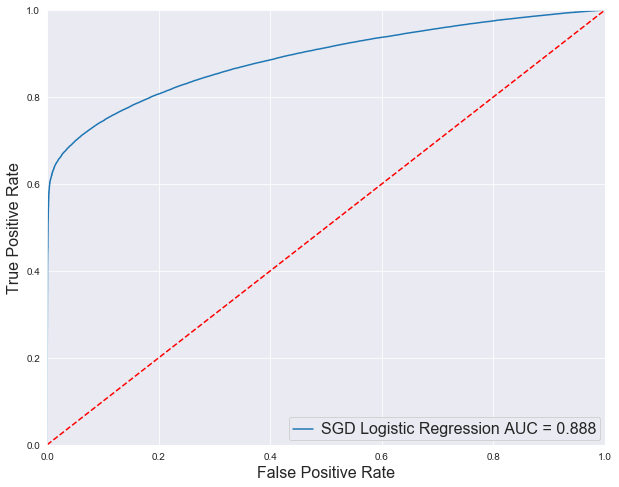

Average cross-validated ROC_AUC for SGD Logistic Regression: 0.8863


In [210]:
model_list = [grid_sgdlogreg.best_estimator_,]
model_name = ['SGD Logistic Regression']

# Plot ROC curve for all my models
fig, ax = plt.subplots(figsize=(10,8))
for i, model in enumerate(model_list):
    if model == 'ensemble':
        w1 = 0.50
        w2 = 0.50
        y_pred = (w1*grid_sgdlogreg.best_estimator_.predict_proba(X_test)[:,1]) 
    
    else:
        y_pred = list(model.predict_proba(X_test)[:,1])
    fpr, tpr, threshold = metrics.roc_curve(y_test, y_pred)
    roc_auc = metrics.auc(fpr, tpr)
    plt.plot(fpr, tpr, label = (model_name[i] + ' AUC = %0.3f' % roc_auc))

plt.legend(loc = 'lower right')
#plt.title('Receiver Operating Characteristic')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
#plt.ylabel('True Positive Rate')
#plt.xlabel('False Positive Rate')
ax.set_xlabel("False Positive Rate",fontsize=16)
ax.set_ylabel("True Positive Rate",fontsize=16)
plt.setp(ax.get_legend().get_texts(), fontsize=16)
plt.savefig(fname='ROC_Curve', dpi=150)
plt.show()
print('Average cross-validated ROC_AUC for SGD Logistic Regression: %0.4f' % grid_sgdlogreg.best_score_)

A .89 AUC is a strong indicator that the model good at distinguishing defaulted loans from loans that will reach maturity. 

This curve, however, is skewed to the left, which means that at lower probability scores, there are more fully paid loans than defaulted ones. This behavior can be fixed by rebalancing the training data. 

In [266]:
# Set cutoff by minimizing default rate within the loans chosen by my model

cutoff = 0.07
y_pred = grid_sgdlogreg.best_estimator_.predict_proba(X_test)

y_class = []
for i in y_pred[:,1]:
    if i >= cutoff:
        y_class.append(1)
    else:
        y_class.append(0)
    
conf_mat = metrics.confusion_matrix(y_test, y_class)
print(conf_mat)
my_default_rate = conf_mat[0,1]/(conf_mat[0,1] + conf_mat[1,1])
total_default_rate = np.sum(conf_mat, axis=1)[0]/(np.sum(conf_mat, axis=1)[0] + np.sum(conf_mat, axis=1)[1])
precision = conf_mat[1,1]/(conf_mat[0,1]+conf_mat[1,1])
TN_rate = conf_mat[0,0]/(conf_mat[0,0]+conf_mat[1,0])
print('Default Rate of Model Loans %.2f' % (my_default_rate*100), '%')
print('Default Rate of All Loans %.2f' % (total_default_rate*100), '%')
print('Probability of correctly identifying a good loan %.2f' % (precision*100), '%')
print('Probability of correctly predicting a defaulting loan %.2f' % (TN_rate*100), '%')

[[   134  31575]
 [    71 165975]]
Default Rate of Model Loans 15.98 %
Default Rate of All Loans 16.03 %
Probability of correctly identifying a good loan 84.02 %
Probability of correctly predicting a defaulting loan 65.37 %


### Plot the backtest

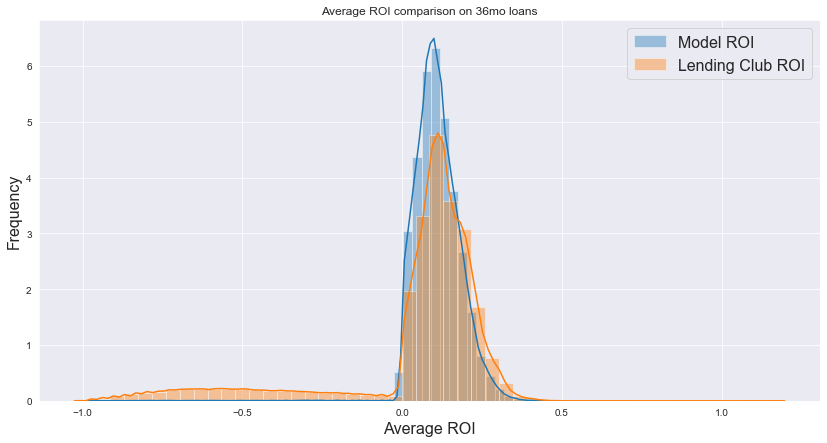

Test Set ROI on Model predicted loans 11.00 %
Benchmark ROI on all loans 4.22 %


In [261]:
df_y_pred=pd.DataFrame({'Prob_fullpay':y_pred[:,1]})
df_pfc=pd.DataFrame(y_test)
df_pfc=df_pfc.reset_index()
df_pfc=df_pfc.merge(df_y_pred,left_index=True,right_index=True).set_index('index')
df_pfc=df_pfc.merge(df_36[['total_pymnt','loan_amnt']],left_index=True,right_index=True)
df_pfc['ROI']=df_pfc['total_pymnt']/df_pfc['loan_amnt']-1

Model_return=df_pfc.loc[(df_pfc['Prob_fullpay'] > .93)]
Model_return=Model_return['ROI']
Default_return=df_pfc.loc[(df_pfc['Prob_fullpay'] > 0)]
Default_return=Default_return['ROI']

fig, ax = plt.subplots(figsize=(14,7))
ax = sns.distplot(tuple(Model_return))
ax = sns.distplot(tuple(Default_return))

ax.set_xlabel("Average ROI",fontsize=16)
ax.set_ylabel("Frequency",fontsize=16)
plt.legend(labels=["Model ROI", 'Lending Club ROI'], fontsize=16)
plt.title('Average ROI comparison on 36mo loans')
plt.show()

print('Test Set ROI on Model predicted loans %.2f' % (np.mean(Model_return)*100), '%')
print('Benchmark ROI on all loans %.2f' % (np.mean(Default_return)*100), '%')

# Conclusions
Our logistic regression provides a 7pt lift, almost tripling average benchmark returns for 36mo term loans. Although these results are positive, more testing needs to be conducted on live data. 

Once data structure become more tuned and developed after running live tests, there will be an opportunity to create a feedback pipeline and build re-enforced learning features into the model. 

A few observations from the data exploration came through in the resulting model. Specifically, the unspervised clustering algorithm very clearly placed defaulting loans in their own cluster. Furthermore, the interest rate distribution on lower grade loans is significantly wider than higher grade loans. This may indicate an opportunity -- perhaps, the model should be tuned so that high yield but low grade loans can be targeted with more confidence.

One data issue this model faces is the static training data. The risk factors of the loan recipients fluctuate overtime and that dynamic is not captured in this dataset. 

